# GAN으로 MNIST 숫자 생성




In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

## 1. MNIST 데이터 불러오기 및 예시 보기

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.3kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.30MB/s]


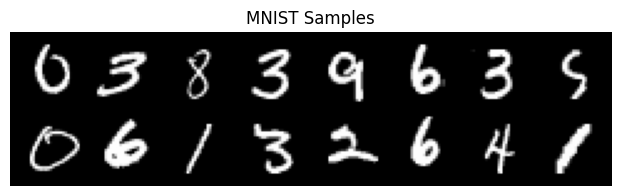

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
mnist = datasets.MNIST(root='.', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=256, shuffle=True)

images, _ = next(iter(dataloader))
grid = make_grid(images[:16], nrow=8, normalize=True)
plt.figure(figsize=(8, 2))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.title('MNIST Samples')
plt.axis('off')
plt.show()

## 2. Generator 모델 정의 (CNN 기반)

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 256, 7, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

## 3. Discriminator 모델 정의 (CNN 기반)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## 4. PyTorch으로 GAN 구성

In [5]:
# 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
noise_dim = 100
lr = 2e-4
epochs = 20

In [6]:
from torch import optim
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

In [7]:
# 생성된 이미지를 시각화할 때 사용할 고정된 noise 벡터 (매 epoch마다 동일한 z 사용)
fixed_noise = torch.randn(16, noise_dim, 1, 1, device=device)

# 학습 루프 시작
for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)  # 배치의 실제 이미지 데이터를 GPU로 이동
        batch_size = real_imgs.size(0)    # 현재 배치 크기

        # ---------------
        # Train Discriminator (D)
        # ---------------

        # 랜덤 노이즈 z로 가짜 이미지 생성
        z = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_imgs = generator(z).detach()  # generator로부터 이미지 생성 (detach로 G에는 gradient 안 감)

        # D가 진짜(real) 이미지를 진짜로 판단하도록 학습
        pred_real = discriminator(real_imgs)
        loss_real = loss_fn(pred_real, torch.ones_like(pred_real))  # 정답은 1, ones_like 1로 이루어진 행렬 생성

        # D가 가짜(fake) 이미지를 가짜로 판단하도록 학습
        pred_fake = discriminator(fake_imgs)
        loss_fake = loss_fn(pred_fake, torch.zeros_like(pred_fake))  # 정답은 0

        # 전체 D의 손실은 진짜 + 가짜에 대한 평균
        loss_d = (loss_real + loss_fake) / 2

        # Discriminator의 gradient 업데이트
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # ---------------
        # Train Generator (G)
        # ---------------

        # 새로운 noise로 가짜 이미지 생성
        z = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_imgs = generator(z)  # G가 만든 이미지

        # G는 D를 속이고 싶어하므로, D가 이를 진짜(1)라고 판단하게 학습
        pred_fake = discriminator(fake_imgs)
        loss_g = loss_fn(pred_fake, torch.ones_like(pred_fake))  # G의 목표는 "1"로 판단되게 만드는 것

        # Generator의 gradient 업데이트
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

    # ----------------------------
    # Epoch 끝난 후 이미지 샘플링
    # ----------------------------
    generator.eval()  # G를 평가 모드로 설정 (dropout, batchnorm 등 고정)
    with torch.no_grad():
        samples = generator(fixed_noise).cpu()  # 고정된 z로 이미지 생성 (학습 trace 없음)

    generator.train()  # 다시 학습 모드로 전환

    # 생성된 이미지들을 grid로 정렬하고 시각화
    grid = make_grid(samples, nrow=4, normalize=True)  # normalize=True → -1~1을 0~1로 변환
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))  # C x H x W → H x W x C
    plt.axis("off")
    plt.title(f"Epoch {epoch}")

    # 이미지 저장
    plt.savefig(f"epoch_{epoch}_sample.png")
    plt.close()


## 6. 학습된 모델로 이미지 생성

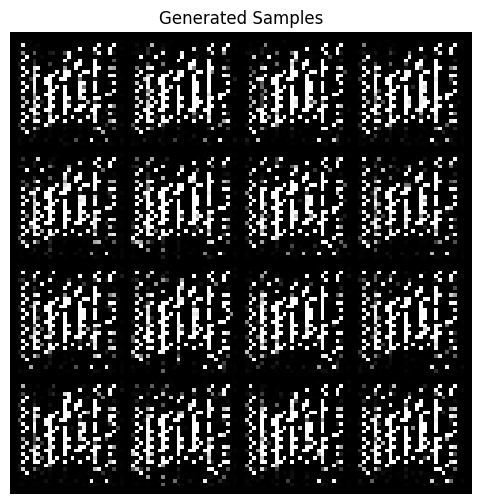

In [9]:
# generator로부터 샘플 생성
generator.eval()
with torch.no_grad():
    samples = generator(fixed_noise).cpu()
grid = make_grid(samples, nrow=4, normalize=True)
plt.figure(figsize=(6, 6))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Generated Samples")
plt.show()